In [ ]:
import plotly

In [ ]:
import numpy as np
import pandas as pd

import os
import tensorflow as tf

from PIL import Image
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split

In [ ]:
def prepare_for_train_test(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test


In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [ ]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

In [ ]:
base_skin_dir = os.path.join('..', 'input')

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [ ]:
os.listdir('/content/drive/MyDrive//Project_phase/ham10000_dataverse_files')

['HAM10000_metadata', 'HAM10000_images_part_2', 'HAM10000_images_part_1']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"/content/drive/MyDrive/Project_phase/ham10000_dataverse_files/", '*', '*.jpg'))}

In [ ]:
type(imageid_path_dict)

dict

In [ ]:
len(imageid_path_dict)

10034

In [ ]:
data = pd.read_csv(os.path.join(base_skin_dir,"/content/drive/MyDrive/Project_phase/ham10000_dataverse_files/",'HAM10000_metadata'))

In [ ]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,dataset
count,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,4
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,vidir_molemax
freq,6,1,6705,5340,5406,2192,3954


In [ ]:
data.isnull().any().sum()

0

In [ ]:
data['age'].fillna(value=int(data['age'].mean()), inplace=True)

data['age'] = data['age'].astype('int32')

In [ ]:
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [ ]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...


In [ ]:
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

KeyboardInterrupt: ignored

In [ ]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


In [ ]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [ ]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

In [ ]:
len(frames)

7

In [ ]:
final_data = pd.concat(frames)

In [ ]:
print(data.shape)
print(final_data.shape)

(10015, 13)
(45756, 13)


In [ ]:
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)


(10015, 28, 28, 3)
(10015, 1)


In [ ]:
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [ ]:
model =create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [ ]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [ ]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 3)

Epoch 1/3
458/458 [==============================] - 14s 12ms/step - loss: 1.7739 - accuracy: 0.4013 - val_loss: 1.1296 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 2/3
458/458 [==============================] - 4s 9ms/step - loss: 0.9807 - accuracy: 0.6247 - val_loss: 0.8168 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 3/3
458/458 [==============================] - 3s 5ms/step - loss: 0.7188 - accuracy: 0.7289 - val_loss: 0.7077 - val_accuracy: 0.7130 - lr: 0.0010


In [ ]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 3s 5ms/step - loss: 0.5517 - accuracy: 0.7934 - val_loss: 0.5569 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 2/50
458/458 [==============================] - 2s 5ms/step - loss: 0.4276 - accuracy: 0.8412 - val_loss: 0.4293 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 3/50
458/458 [==============================] - 2s 5ms/step - loss: 0.3501 - accuracy: 0.8696 - val_loss: 0.3190 - val_accuracy: 0.8843 - lr: 0.0010
Epoch 4/50
458/458 [==============================] - 2s 5ms/step - loss: 0.2890 - accuracy: 0.8932 - val_loss: 0.3107 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 5/50
458/458 [==============================] - 2s 5ms/step - loss: 0.2211 - accuracy: 0.9185 - val_loss: 0.3215 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 6/50
458/458 [==============================] - 2s 5ms/step - loss: 0.2145 - accuracy: 0.9193 - val_loss: 0.2676 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 7/50
458/458 [==============================] - 2s 5ms/step - lo

In [ ]:
model

In [ ]:
model.save('Skin_Cancer.sav')

In [ ]:
model.save_weights("Skin_Cancer.hdf5")

In [ ]:
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)v

In [ ]:
final_data.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[234, 134, 155], [238, 140, 164], [234, 130,...",0
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[214, 121, 154], [216, 124, 159], [218, 124,...",0
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[234, 146, 167], [236, 149, 171], [233, 149,...",0


In [ ]:
final_data['age'].dtype

dtype('int32')

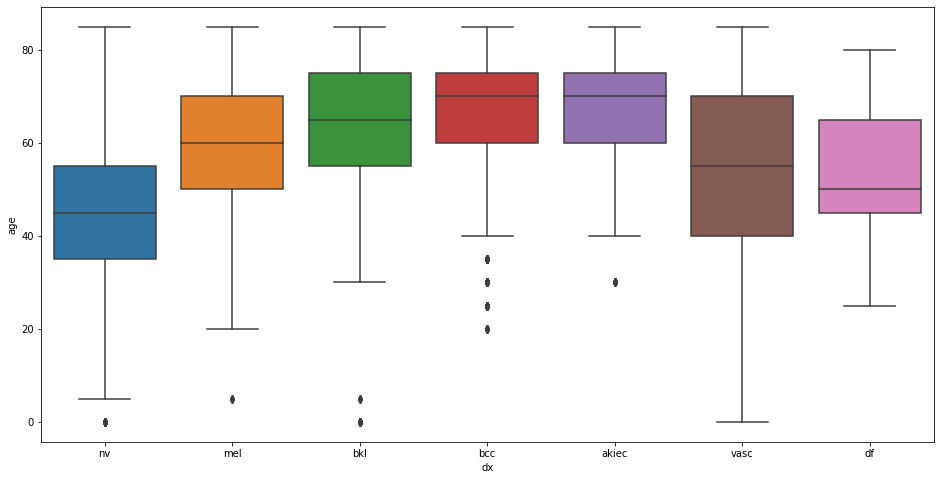

In [ ]:
plt.figure(figsize=(16,8))

sns.boxplot(x=final_data['dx'],y=final_data['age'])

In [ ]:
final_data.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[234, 134, 155], [238, 140, 164], [234, 130,...",0
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[214, 121, 154], [216, 124, 159], [218, 124,...",0
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,vidir_molemax,Melanocytic nevi (nv),/content/drive/MyDrive/Project_phase/ham10000_...,"[[[234, 146, 167], [236, 149, 171], [233, 149,...",0
